In [1]:
import matplotlib.pyplot as plt
import time
import random

In [2]:
class Edge:
    def __init__(self, frm, to) -> None:
        # the smaller edge is alway 'from', while the greater is always 'to'
        self.frm, self.to = (frm, to) if frm < to else (to, frm)

In [3]:
class TRIEST_base:
    def __init__(self, m: int=100) -> None:
        if m < 6:
            raise Exception('M is <6')
        self.t = 0 # time t incremented evety time we receive an edge
        self.tau = 0 #global counter τ for the estimation of the global number of triangles.
        self.edge_sample = set() #sample
        self.m = m #memory: max number of edges to keep
        self.counters = {} #to compute estimations of the global and local number of triangles

    # Does the reservior sampling
    def sample_edge(self, edge):

        def flip_biased_coin() -> bool:
            return random.random() <= (self.m/self.t)

        if self.t < self.m:
            return True
        elif flip_biased_coin():
            unlucky_element = random.sample(self.edge_sample, 1)[0]
            self.edge_sample.remove(unlucky_element)
            # self.update_counters('remove', edge)
            self.update_counters('remove', unlucky_element)
            return True
        return False

    def update_counters(self, operation, edge: Edge):
        s1 = set()
        s2 = set()
        for element in self.edge_sample:
            if element.frm == edge.frm:
                s1.add(element.to)
            if element.to == edge.frm:
                s1.add(element.frm)
            if element.frm == edge.to:
                s2.add(element.to)
            if element.to == edge.to:
                s2.add(element.frm)
        # vertex is the overlap between s1 and s2
        for vertex in (s1 & s2):
            if operation == 'add':
                self.tau += 1
                self.counters[vertex] = self.counters.get(vertex, 0) + 1
                self.counters[edge.frm] = self.counters.get(edge.frm, 0) + 1
                self.counters[edge.to] = self.counters.get(edge.to, 0) + 1
            elif operation == 'remove':
                self.tau -= 1
                self.counters[vertex] = self.counters.get(vertex, 0) - 1
                self.counters[edge.frm] = self.counters.get(edge.frm, 0) - 1
                self.counters[edge.to] = self.counters.get(edge.to, 0) - 1
                if self.counters[vertex] <= 0:
                    del self.counters[vertex]
                    del self.counters[edge.frm]
                    del self.counters[edge.to]


    def algo_start(self, edge_stream):
        for edge in edge_stream:
            self.t += 1
            if self.sample_edge(edge):
            # if self.sample_edge():
                self.edge_sample.add(edge)
                self.update_counters('add', edge)
        est = max([1, (self.t*(self.t-1)*(self.t-2))/(self.m*(self.m-1)*(self.m-2))])
        return self.tau * est


In [4]:
class TRIEST_improved:
    def __init__(self, m: int=100) -> None:
        if m < 6:
            raise Exception('M is <6')
        self.t = 0
        self.tau = 0
        self.edge_sample = set()
        self.m = m
        self.counters = {}

    # def sample_edge(self):
    def sample_edge(self, edge):

        def flip_biased_coin() -> bool:
            return random.random() <= (self.m/self.t)

        if self.t < self.m:
            return True
        elif flip_biased_coin():
            unlucky_element = random.sample(self.edge_sample, 1)[0]
            self.edge_sample.remove(unlucky_element)
            return True
        return False

    def update_counters(self, edge: Edge):
        s1 = set()
        s2 = set()
        for element in self.edge_sample:
            if element.frm == edge.frm:
                s1.add(element.to)
            if element.to == edge.frm:
                s1.add(element.frm)
            if element.frm == edge.to:
                s2.add(element.to)
            if element.to == edge.to:
                s2.add(element.frm)
        # vertex is the overlap between s1 and s2
        for vertex in (s1 & s2):
            weight = max([1, (self.t-1)*(self.t-2)/self.m/(self.m-1)])
            self.tau += weight
            self.counters[vertex] = self.counters.get(vertex, 0) + weight
            self.counters[edge.frm] = self.counters.get(edge.frm, 0) + weight
            self.counters[edge.to] = self.counters.get(edge.to, 0) + weight


    def algo_start(self, edge_stream):
        for edge in edge_stream:
            self.t += 1
            self.update_counters(edge)
            if self.sample_edge(edge):
                self.edge_sample.add(edge)
        return self.tau

In [5]:
test_set = set()
with open('data_a_lot.txt') as f:
    for line in f:
        content = line.split()
        # get rid of duplicates
        if content[0] != content[1]:
            test_set.add(Edge(content[0], content[1]))

Testing TRIEST base:
test_set length: 88234
Expected value: 2066894.7530409289
True value: 1611972
Difference: 28 %


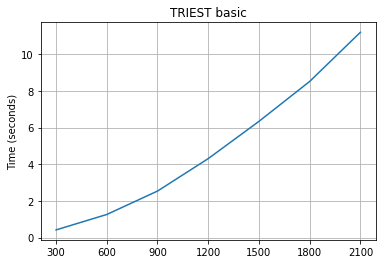

In [6]:
# TRIEST base
print('Testing TRIEST base:')
sample_size = 1000
print('test_set length:', len(test_set))
expected = TRIEST_base(sample_size).algo_start(test_set)
print('Expected value:', expected)
start = time.time()
true = TRIEST_base(len(test_set)).algo_start(test_set)
exec_time = time.time() - start
print('True value:', true)
print('Difference:', round(abs(expected - true) / true * 100), '%')

sizes = [300, 600, 900, 1200, 1500, 1800, 2100]
values = []
times = []
true_values = [true for _ in range(len(sizes))]
true_times = [exec_time for _ in range(len(sizes))]

for size in sizes:
    start = time.time()
    expected = TRIEST_base(size).algo_start(test_set)
    end = time.time()
    times.append(end-start)
    values.append(round(expected))

plt.title('TRIEST basic')
plt.plot(sizes, values)
plt.plot(sizes, true_values)
plt.ylabel('Number of triangles')
plt.xticks(sizes)
plt.grid(True)
plt.savefig('base_number_of_triangles.png')

plt.clf()
plt.title('TRIEST basic')
plt.plot(sizes, times)
# plt.plot(sizes, true_times)
plt.ylabel('Time (seconds)')
plt.xticks(sizes)
plt.grid(True)
plt.savefig('base_times.png')

Testing TRIEST improved:
test_set length: 88234
Expected value: 1405616.6091871876
True value: 1612010
Difference: 13 %


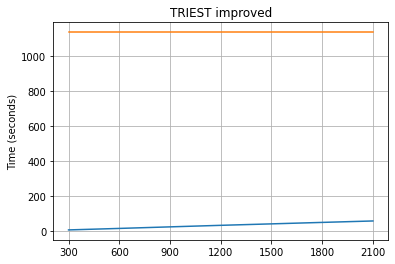

In [7]:
################################################################################
# TRIEST improved
print('Testing TRIEST improved:')
sample_size = 1000
print('test_set length:', len(test_set))
expected = TRIEST_improved(sample_size).algo_start(test_set)
print('Expected value:', expected)
start = time.time()
true = TRIEST_improved(len(test_set)).algo_start(test_set)
exec_time = time.time() - start
print('True value:', true)
print('Difference:', round(abs(expected - true) / true * 100), '%')

sizes = [300, 600, 900, 1200, 1500, 1800, 2100]
values = []
times = []
true_values = [true for _ in range(len(sizes))]
true_times = [exec_time for _ in range(len(sizes))]

for size in sizes:
    start = time.time()
    expected = TRIEST_improved(size).algo_start(test_set)
    end = time.time()
    times.append(end-start)
    values.append(round(expected))

plt.clf()
plt.title('TRIEST improved')
plt.plot(sizes, values)
plt.plot(sizes, true_values)
plt.ylabel('Number of triangles')
plt.xticks(sizes)
plt.grid(True)
plt.savefig('improved_number_of_triangles.png')

plt.clf()
plt.title('TRIEST improved')
plt.plot(sizes, times)
plt.plot(sizes, true_times)
plt.ylabel('Time (seconds)')
plt.xticks(sizes)
plt.grid(True)
plt.savefig('improved_times.png')

In [ ]:
################################################################################
# TRIEST base big dataset
test_set = set()
with open('web-Stanford.txt') as f:
    for line in f:
        content = line.split()
        if content[0] != content[1]:
            test_set.add(Edge(content[0], content[1]))

print('Testing TRIEST base:')
sample_size = 3000
print('test_set length:', len(test_set))
expected = TRIEST_base(sample_size).algo_start(test_set)
print('Expected value:', expected)
true_value = TRIEST_base(len(test_set)).algo_start(test_set)
print('True Value: ', true_value)
print('Difference:', round(abs(expected - true_value) / true_value * 100), '%')

Testing TRIEST base:
test_set length: 2312497
Expected value: 55933687575.48788
